<pre> &#8593;&#8593;&#8593;&#8593;&#8593;&#8593;</pre>

**To view this notebook as a slideshow click on the deck icon ![deck](https://raw.githubusercontent.com/deathbeds/jupyterlab-deck/main/docs/_static/deck.svg) above.**

For a better slideshow experience, set font sizes to 24px by going to Settings -> Fonts -> Code/Content -> Size.

<center>
<h1>Reading RNTuple data with Uproot</h1>
<h2>Andres Rios-Tascon</h2>
<h4>PyHEP 2024</h4>
<img src="images/PU_lockup.png" style="height:50px;"/>&nbsp&nbsp&nbsp&nbsp&nbsp<img src="images/Iris-hep-4-no-long-name.png" style="height:50px;"/>
</center>

## Outline

- Introduction and motivation for RNTuple.
- Status of RNTuple support in Uproot.
- Hands-on demo.
- Future work and outlook

## What is RNTuple and why should we care?

- `RNTuple` is a modern serialization format that will replace `TTree`.

- `TTree` has become outdated and bloated.
  - Inefficient storing and reading of nested and/or jagged collections.
  - Lots of special cases and hacky implementations.
  - Virtually impossible to fully support on `uproot`.
 
<center><img src="images/ttree_current_status.svg" style="height:400px;"/></center>

- `RNTuple` will bring many improvements.
  - Simple and modern design (and has a formal spec).
  - Focuses on native data types.
  - Columnar layout very similar to `awkward`.
  - Much faster performance and designed for parallelization.
  - Simpler design should alow for almost 100% support on `uproot`.

## RNTuple performance comparison

<br/>
<br/>
<br/>

<center>
<img src="images/rntuple_comparison.png" style="height:200px;"/>
</center>

<br/>
<br/>
<br/>

Image taken from [arXiv:2204.09043](https://arxiv.org/abs/2204.09043).

## RNTuple timeline

<br/>
<br/>
<br/>

<center>
<img src="images/rntuple_timeline.png" style="height:100px;"/>
</center>

<br/>
<br/>
<br/>

Image taken from <https://doi.org/10.1051/epjconf/202429506020>.

**Version 1.0.0 of specification is expected to be done by the end of this year.**

We expect to have most functionality working on `uproot` by the time this happens!

## RNTuple in Uproot

- Initial implementation was written by Jerry Ling.
  - Fairly complete reading support.
  - Basic writing support.

- A significant update to the `RNTuple` spec was released earlier this year, which completely broke the existing implementation.

- We have fixed and reworked the reading functionality, adding new features from the spec.

<center><img src="images/rntuple_current_status.svg" style="height:400px;"/></center>

- We are aiming to have the interface be the same as (or very similar to) the one for `TTree`.

<center>
<h2>Let's look at a concrete example</h2>
</center>

## Example RNTuple

Let's consider an example<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) where we have the following data:

| Trigger (bool) | Missing ET {float, float} | Lepton ids (vector) |
| -------------- | ------------------------- | ------------------- |
| False          | {et: 79.7, phi: 2.83}     | []                  |
| True           | {et: 78, phi: 0.62}       | [11, -11]           |
| False          | {et: 10, phi: -2.78}      | [-13, -11]          |
| True           | {et: 14.3, phi: 1.31}     | [11, 11, -13]       |
| True           | {et: 83.2, phi: 2.76}     | [11]                |

<br/>
<br/>

<a name="cite_note-1"></a>1. [^](#cite_ref-1) This example is based on [this talk](https://indico.cern.ch/event/1222943/) by Jerry Ling.

## Data layout

```mermaid
flowchart BT
    A[\"(top level)"/]
    B("trig (bool)") --> A
    C("met (struct)") --> A
    D("lep_pid (std::vector&lt;int&gt;)") --> A
    E[("column (data)")] --> B
    F("et (float)") --> C
    G("phi (float)") --> C
    H[("column (data)")] --> F
    I[("column (data)")] --> G
    J[("column (offset)")] --> D
    K("_0 (int)") --> D
    L[("column (data)")] --> K
```

We will see that this very closely matches the data layout in `awkward`!

## ROOT code

We can create an RNTuple with this data by using the following ROOT code.

In [35]:
from IPython.display import Code
with open("example_rntuple.C") as f:
    code = f.read()
Code(code, language='cpp')

#include <ROOT/RNTupleModel.hxx>
#include <ROOT/RNTupleWriter.hxx>
 
#include <TMath.h>
#include <TRandom.h>
#include <TSystem.h>
 
#include <cstdio>
#include <iostream>
#include <memory>
#include <vector>
#include <utility>
 
using RNTupleModel = ROOT::Experimental::RNTupleModel;
using RNTupleWriter = ROOT::Experimental::RNTupleWriter;
 
constexpr char const* kNTupleFileName = "example_rntuple.root";
constexpr int kNEvents = 5;
constexpr int lepIds[4] = {11, -11, 13, -13};

struct MET {
   float et;
   float phi;
};
 
void example_rntuple()
{
   auto model = RNTupleModel::Create();
 
   auto fldTrig   = model->MakeField<bool>("trig");
   auto fldMET    = model->MakeField<MET>("met");
   auto fldLepPid = model->MakeField<std::vector<int>>("lep_pid");
 
   auto ntuple = RNTupleWriter::Recreate(std::move(model), "ntpl", kNTupleFileName);
 
   gRandom->SetSeed(42);
   for (int i = 0; i < kNEvents; i++) {
      *fldTrig = gRandom->Rndm() > 0.5;

      fldMET->et   = gRandom->Rndm()*100;
      fldMET->phi  = (2*gRandom->Rndm() - 1)*TMath::Pi();
 
      fldLepPid->clear();
      int nlep = gRandom->Integer(5);
      for (int j = 0; j < nlep; ++j) {
         fldLepPid->emplace_back(lepIds[gRandom->Integer(4)]);

      }
 
      ntuple->Fill();
   }
}

## Using `uproot` to read this RNTuple

As a quick reminder, `uproot` can be installed with `pip install uproot` or `conda install -c conda-forge uproot`. If you're using this notebook on JupyterLite then it is already installed.

Let's start by importing `uproot`.

In [74]:
import uproot

Let's now open this example file and see what's inside.

In [75]:
f = uproot.open("example_rntuple.root")
f.classnames()

{'ntpl;1': 'ROOT::Experimental::RNTuple'}

Let's now look at this RNTuple and briefly take a look at the data layout that we discussed before.

In [76]:
ntpl = f["ntpl"]

In [72]:
for i,fr in enumerate(ntpl.field_records):
    print(f"field_name={fr.field_name:<7} type_name={fr.type_name:<25} idx={i} parent_idx={fr.parent_field_id}")

field_name=trig    type_name=bool                      idx=0 parent_idx=0
field_name=met     type_name=MET                       idx=1 parent_idx=1
field_name=et      type_name=float                     idx=2 parent_idx=1
field_name=phi     type_name=float                     idx=3 parent_idx=1
field_name=lep_pid type_name=std::vector<std::int32_t> idx=4 parent_idx=4
field_name=_0      type_name=std::int32_t              idx=5 parent_idx=4


In [77]:
for cr in ntpl.column_records:
    print(f"idx={cr.idx}, field_id={cr.field_id}, type={cr.type:0>2}, nbits={cr.nbits:0>2}")

idx=0, field_id=0, type=06, nbits=01
idx=1, field_id=2, type=17, nbits=32
idx=2, field_id=3, type=17, nbits=32
idx=3, field_id=4, type=14, nbits=64
idx=4, field_id=5, type=27, nbits=32


### Let's now actually read the data and put it into arrays!

In [79]:
arrays = ntpl.arrays()
arrays

<Array [{trig: False, met: {...}, ...}, ...] type='5 * {trig: bool, met: {e...'>

Now everything works in the usual `awkward` fashion.

In [80]:
arrays.lep_pid

<Array [[], [11, -11], [...], [11, 11, -13], [11]] type='5 * var * int32'>

### We can already ready complex files

Here is an example of a file produced by an ATLAS workflow.

In [104]:
url = "https://github.com/scikit-hep/scikit-hep-testdata/raw/main/src/skhep_testdata/data/DAOD_TRUTH3_RC2.root"

# When not using WASM we can read the file directly
# f = uproot.open(f"simplecache::{url}")

# For WASM we need some workarounds
#import requests
#r = requests.get(f"https://corsproxy.io/?{url}") # Please be careful when using a CORS proxy
#open("DAOD_TRUTH3_RC2.root", "wb").write(r.content)
f = uproot.open("DAOD_TRUTH3_RC2.root")

In [105]:
f.classnames()

{'##Params;5': 'TTree',
 '##Params;4': 'TTree',
 '##Params;3': 'TTree',
 '##Params;2': 'TTree',
 '##Params;1': 'TTree',
 '##Shapes;5': 'TTree',
 '##Shapes;4': 'TTree',
 '##Shapes;3': 'TTree',
 '##Shapes;2': 'TTree',
 '##Shapes;1': 'TTree',
 '##Links;5': 'TTree',
 '##Links;4': 'TTree',
 '##Links;3': 'TTree',
 '##Links;2': 'TTree',
 '##Links;1': 'TTree',
 'POOLCollectionTree;4': 'TTree',
 'POOLCollectionTree;3': 'TTree',
 'POOLCollectionTree;2': 'TTree',
 'POOLCollectionTree;1': 'TTree',
 'MetaData;4': 'TTree',
 'MetaData;3': 'TTree',
 'MetaData;2': 'TTree',
 'MetaData;1': 'TTree',
 'MetaDataHdr;4': 'TTree',
 'MetaDataHdr;3': 'TTree',
 'MetaDataHdr;2': 'TTree',
 'MetaDataHdr;1': 'TTree',
 'MetaDataHdrForm;4': 'TTree',
 'MetaDataHdrForm;3': 'TTree',
 'MetaDataHdrForm;2': 'TTree',
 'MetaDataHdrForm;1': 'TTree',
 'RNT:CollectionTree;1': 'ROOT::Experimental::RNTuple',
 'RNT:POOLContainer;1': 'ROOT::Experimental::RNTuple',
 'RNT:POOLContainerForm;1': 'ROOT::Experimental::RNTuple'}

In [106]:
ntpl = f["RNT:CollectionTree"]

In [107]:
arrays = ntpl.arrays()
arrays

<Array [{index_ref: ..., ...}, ..., {...}] type='10 * {index_ref: uint64, "...'>

### We also have good performance when reading large(-ish) files
### (more on this later)

Here is an example with a ~100 MB file.

In [108]:
url = "http://root.cern/files/tutorials/ntpl004_dimuon_v1rc2.root"

# When not using WASM we can read the file directly
# f = uproot.open(f"simplecache::{url}")

# For WASM we need some workarounds
#import requests
#r = requests.get(f"https://corsproxy.io/?{url}") # Please be careful when using a CORS proxy
#open("ntpl004_dimuon_v1rc2.root", "wb").write(r.content)
f = uproot.open("ntpl004_dimuon_v1rc2.root")

In [109]:
f.classnames()

{'Events;1': 'ROOT::Experimental::RNTuple'}

In [111]:
ntpl = f["Events"]
arrays = ntpl.arrays()
arrays

<Array [{Muon_pt: [...], ...}, ..., {...}] type='4000000 * {Muon_pt: var * ...'>

### Interactions with Scikit-HEP ecosystem remain unchanged

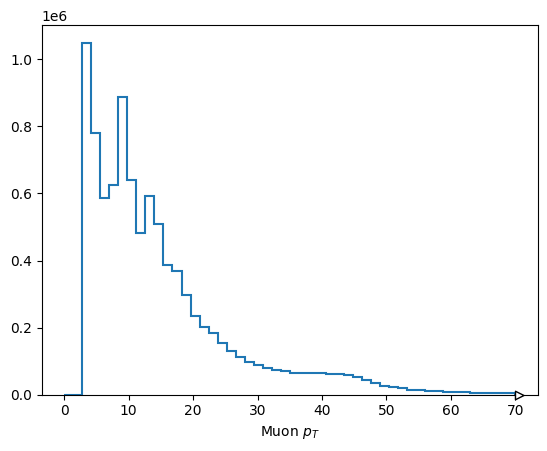

In [139]:
import awkward as ak
from hist import Hist

h = Hist.new.Regular(50, 0, 70, name="pt", label="Muon $p_T$").Double()
h.fill(pt=ak.flatten(arrays.Muon_pt))
h.plot();

## Future work and outlook

- Although `RNTuple` reading already works, there is still a significant amount of work that needs to be done.

- Lazy-reading will be implemented with `dask`, just how it has been done for `TTree`.

- `RNTuple` writing needs to be fixed and likely heavily rewritten.

- We are aiming to keep up to date with changes in `RNTuple` spec and be ready for v1.0.0.

- `uproot` will become even more useful since it should support almost 100% of the `RNTuple` spec, and so should be almost equivalent to `ROOT` for reading and writing.

<center><img src="images/rntuple_goal.svg" style="height:400px;"/></center>